<a href="https://colab.research.google.com/github/samyumobi/Text-recognition-in-vehicle-images/blob/main/vehicle_license_plate_detection_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

We create the variable X containing all the images of cars by resizing them.



In [2]:
IMAGE_SIZE = 224

In [3]:
import os,glob
img_dir = "/content/drive/MyDrive/archive (1).zip (Unzipped Files)/images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations'
text_files = ['/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
resizeannotation("/content/drive/MyDrive/archive (1).zip (Unzipped Files)/annotations/Cars147.xml")

[188, 141, 101, 104]

In [9]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [10]:
import numpy as np

np.array(X).shape

(428, 224, 224, 3)

In [11]:
np.array(y).shape

(428, 4)

And we display the first eighteen image of the dataset : 

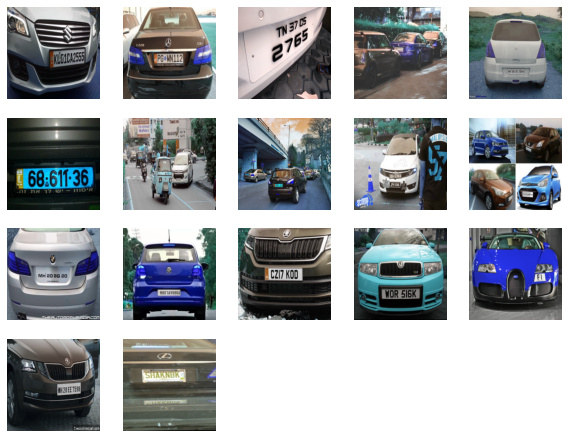

In [12]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

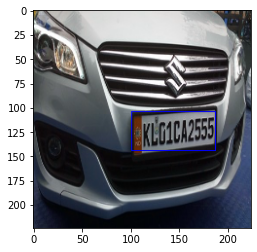

In [13]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


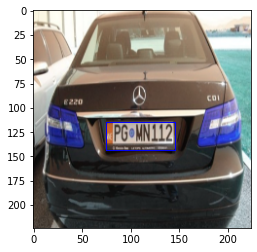

In [14]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [15]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [16]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [18]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [19]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-

In [20]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [21]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=5, verbose=1)

Epoch 1/5
62/62 [==============================] - 125s 2s/step - loss: 0.0410 - accuracy: 0.4481 - val_loss: 0.0152 - val_accuracy: 0.7714
Epoch 2/5
62/62 [==============================] - 110s 2s/step - loss: 0.0093 - accuracy: 0.7331 - val_loss: 0.0167 - val_accuracy: 0.8286
Epoch 3/5
62/62 [==============================] - 111s 2s/step - loss: 0.0055 - accuracy: 0.8105 - val_loss: 0.0100 - val_accuracy: 0.6286
Epoch 4/5
62/62 [==============================] - 111s 2s/step - loss: 0.0038 - accuracy: 0.8471 - val_loss: 0.0104 - val_accuracy: 0.8286
Epoch 5/5
62/62 [==============================] - 111s 2s/step - loss: 0.0016 - accuracy: 0.8750 - val_loss: 0.0107 - val_accuracy: 0.8571


In [22]:
model.save('my_model.h5', overwrite=True) 

In [23]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 80.23%


In [24]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

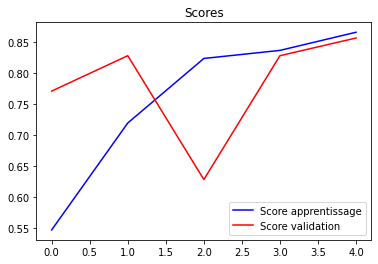

In [25]:
plot_scores(train)

## DETECTION 

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


100/100 [==============================] - 30s 299ms/step - loss: 0.0073 - accuracy: 0.8023
Test results 
 Loss: 0.0073079452849924564 
 Accuracy 0.8023256063461304


In [27]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

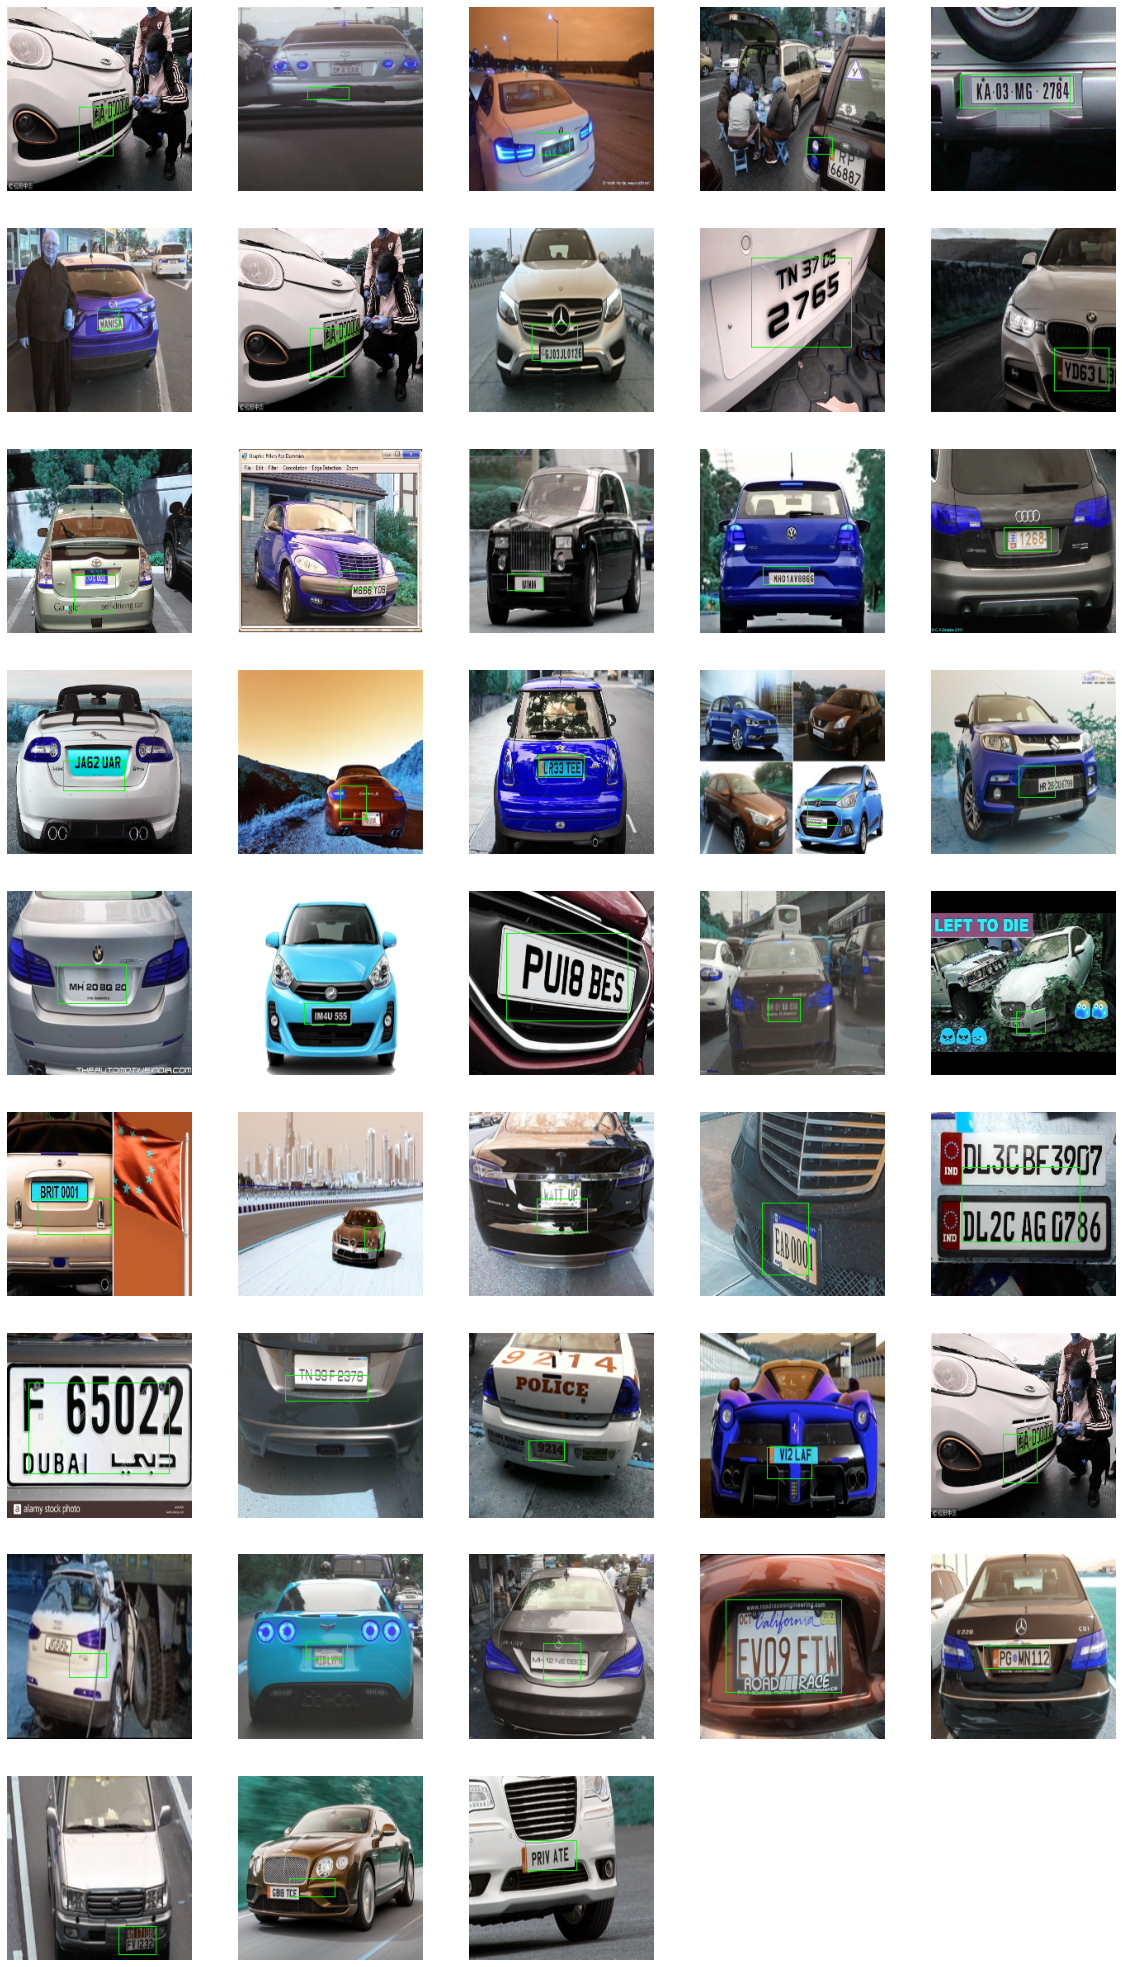

In [28]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



In [29]:
%tensorboard --logdir logs/gradient_tape


UsageError: Line magic function `%tensorboard` not found.


#  Deploy the model

In [83]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import tensorflow as tf
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 492
drwxr-xr-x 2 root root   4096 Jul 30 16:30 assets
-rw-r--r-- 1 root root      0 Jul 30 17:52 keras_metadata.pb
-rw-r--r-- 1 root root 494136 Jul 30 17:52 saved_model.pb
drwxr-xr-x 2 root root   4096 Jul 30 17:52 variables


## Examine saved model

## Serve the model

In [84]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [85]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.5.1).
0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.


In [86]:
os.environ["MODEL_DIR"] = MODEL_DIR

!nohup tensorflow_model_server \
    --rest_api_port = 8981 \
    --model_name = test \
    --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [87]:

!tail server.log

	--version=false                  	bool	Display version
	--monitoring_config_file=""      	string	If non-empty, read an ascii MonitoringConfig protobuf from the supplied file name
	--remove_unused_fields_from_bundle_metagraph=true	bool	Removes unused fields from MetaGraphDef proto message to save memory.
	--prefer_tflite_model=false      	bool	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Prefer TensorFlow Lite model from `model.tflite` file in SavedModel directory, instead of the TensorFlow model from `saved_model.pb` file. If no TensorFlow Lite model found, fallback to TensorFlow model.
	--num_tflite_pools=2             	int32	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Number of TFLite interpreters in an interpreter pool of TfLiteSession. Typically there is one TfLiteSession for each TF Lite model that is loaded. If not set, will be auto set based on number of CPUs.
	--num_tflite_interpreters_per_pool=1	int32	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Number of TFLite interpreters in an interpreter po

## Make a request to your model in TensorFlow Serving

In [96]:
# def show(idx, title):
#   plt.figure()
#   plt.imshow(y[idx].reshape(28,28))
#   plt.axis('off')
#   plt.title('\n\n{}'.format(title), fontdict={'size': 16})

# import random
# rando = random.randint(0,len(y)-1)
# show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [91]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": y[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 82352941, 0.3058823529411765, 0.01568627450980392]]}


## Make REST requests

In [95]:
# !pip install -q requests

# import requests
# headers = {"content-type": "application/json"}
# json_response = requests.post('http://localhost:8981/v1/models/fashion_model:predict', data=data, headers=headers)
# predictions = json.loads(json_response.text)['predictions']

# # show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
# #   class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

In [94]:
# headers = {"content-type": "application/json"}
# json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
# predictions = json.loads(json_response.text)['predictions']

# for i in range(0,3):
#   show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
#     class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))